# Прогнозирование стоимости автомобиля BMW

# EDA обучающей выборки с AVITO

In [32]:
# Загрузка библиотек

import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import ExtraTreeRegressor
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from catboost import CatBoostRegressor

from tqdm import tqdm
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random

from itertools import combinations
from scipy.stats import ttest_ind


# EDA тренировочной выборки ( с авито)

In [33]:
# Загрузка датасета и удаление пустых строк.

cars = pd.read_csv('car_1_88.csv')
cars.dropna(subset = ['Марка'], inplace=True)  
cars.dropna(subset = ['Price'], inplace=True)
cars = cars.reset_index(drop=True)      # индексирование по порядку
cars

,Марка,Модель,Поколение,Модификация,Год выпуска,Пробег,Состояние,Владельцев по ПТС,Тип кузова,Количество дверей,Тип двигателя,Коробка передач,Привод,Руль,Цвет,Комплектация,Price,Describe
0,BMW,5 серия,G30/G31 (2016—н. в.),530i 2.0 xDrive Steptronic (249 л.с.),2018.0,45357 км,не битый,1,седан,4.0,бензин,автомат,полный,левый,чёрный,NaN,2747000.0,"[<div class=""item-description""> <div class=""it..."
1,BMW,5 серия,F10/F11 (2009—2013),530d 3.0 xDrive AT (258 л.с.),2011.0,172467 км,не битый,2,седан,4.0,дизель,автомат,полный,левый,чёрный,NaN,1310000.0,"[<div class=""item-description""> <div class=""it..."
2,BMW,1 серия,F20/F21 (2011—2015),116i 1.6 AT (136 л.с.),2012.0,193000 км,не битый,4+,хетчбэк,5.0,бензин,автомат,задний,левый,белый,Базовая,520000.0,"[<div class=""item-description""> <div class=""it..."
3,BMW,X5,E70 рестайлинг (2010—2013),30d 3.0 AT (245 л.с.),2012.0,104153 км,не битый,1,внедорожник,5.0,дизель,автомат,полный,левый,серый,NaN,1759000.0,"[<div class=""item-description""> <div class=""it..."
4,BMW,X6,F16 (2014—н. в.),35i 3.0 AT (306 л.с.),2016.0,42100 км,не битый,2,внедорожник,5.0,бензин,автомат,полный,левый,белый,Базовая,2749900.0,"[<div class=""item-description""> <div class=""it..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4010,BMW,3 серия,F30/F31 рестайлинг (2015—н. в.),320i 2.0 Steptronic (184 л.с.),2017.0,35000 км,не битый,1,седан,4.0,бензин,автомат,задний,левый,чёрный,SE,1800000.0,"[<div class=""item-description""> <div class=""it..."
4011,BMW,X5,G05 (2018—н. в.),30d 3.0 xDrive Steptronic (249 л.с.),2019.0,3844 км,не битый,1,внедорожник,5.0,дизель,автомат,полный,левый,серый,NaN,5449978.0,"[<div class=""item-description""> <div class=""it..."
4012,BMW,5 серия,F10/F11 рестайлинг (2013—2017),520i 2.0 AT (184 л.с.),2016.0,78000 км,не битый,3,седан,4.0,бензин,автомат,задний,левый,коричневый,Business,1250000.0,"[<div class=""item-description""> <div class=""it..."
4013,BMW,5 серия,F10/F11 рестайлинг (2013—2017),520i 2.0 AT (184 л.с.),2016.0,105600 км,не битый,1,седан,4.0,бензин,автомат,задний,левый,чёрный,NaN,1339000.0,"[<div class=""item-description""> <div class=""it..."


Проверим сначала общую информацию по датасету

In [34]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4015 entries, 0 to 4014
Data columns (total 18 columns):
Марка                4015 non-null object
Модель               4015 non-null object
Поколение            4015 non-null object
Модификация          4015 non-null object
Год выпуска          4015 non-null float64
Пробег               4015 non-null object
Состояние            4015 non-null object
Владельцев по ПТС    4015 non-null object
Тип кузова           4015 non-null object
Количество дверей    4015 non-null float64
Тип двигателя        4015 non-null object
Коробка передач      4015 non-null object
Привод               4015 non-null object
Руль                 4011 non-null object
Цвет                 4015 non-null object
Комплектация         3278 non-null object
Price                4015 non-null float64
Describe             4015 non-null object
dtypes: float64(3), object(15)
memory usage: 564.7+ KB


In [35]:
# Пустых значений не много, содержатся в столбцах Руль и Комплектация

cars.isnull().sum()

Марка                  0
Модель                 0
Поколение              0
Модификация            0
Год выпуска            0
Пробег                 0
Состояние              0
Владельцев по ПТС      0
Тип кузова             0
Количество дверей      0
Тип двигателя          0
Коробка передач        0
Привод                 0
Руль                   4
Цвет                   0
Комплектация         737
Price                  0
Describe               0
dtype: int64

In [36]:
# Переименуем столбцы по аналогии с тестовым датасетом

cars.columns = ([
    'brand',
    'Model',
    'modelDate',
    'name',
    'productionDate',
    'mileage',
    'state',
    'owners',
    'bodyType',
    'numberOfDoors',
    'fuelType',
    'vehicleTransmission',
    'drive',
    'wheel',
    'color',
    'equipment',
    'price',
    'describe'
 #   'enginePower',
#    'engineDisplacement',
#    'customs',
#    'id',
])

In [37]:
# Сделаем предварительный анализ столбцов на адекватность значений и выбросы.
# Столбцы требуют парсинга: modelDate, name, mileage
# Столбцы требуют удаления: state, brand
# Столбцы требуют маппинга в соответствии с тестовой базой: owners, equipment
# Столбцы: state, owners, bodyType, numberOfDoors, fuelType, vehicleTransmission, drive, wheel, color, имеют 
# категориальные значения, выбросы в них отсутствуют. 


def uniq_all (c):
# Уникальные значения по всем столбцах 

    print("Уникальные значения столбца:", c)
    print(pd.DataFrame(cars[c].unique()))


for col in cars.columns:
    uniq_all(col)

Уникальные значения столбца: brand
     0
0  BMW
Уникальные значения столбца: Model
                        0
0                 5 серия
1                 1 серия
2                      X5
3                      X6
4                 7 серия
5                    X5 M
6                 3 серия
7                 6 серия
8                      X3
9                 2 серия
10                     X1
11                4 серия
12                     M3
13                     X7
14                     X4
15     4 серия Gran Coupe
16                     M5
17                     Z3
18     6 серия Gran Coupe
19                   X6 M
20                8 серия
21             5 серия GT
22                     M6
23                     i3
24             3 серия GT
25                     X2
26             6 серия GT
27                   X4 M
28                     M4
29                     i8
30                    326
31                     Z4
32   2 серия Grand Tourer
33                    321
34  2 

In [38]:
# Пропуски в поле "wheel" заполним большинством значений

display(cars.wheel.value_counts())
display(cars[pd.isna(cars.wheel)])
cars['wheel'] = cars['wheel'].fillna('левый')

левый     4004
правый       7
Name: wheel, dtype: int64

,brand,Model,modelDate,name,productionDate,mileage,state,owners,bodyType,numberOfDoors,fuelType,vehicleTransmission,drive,wheel,color,equipment,price,describe
28,BMW,X5,E70 рестайлинг (2010—2013),35i 3.0 AT (306 л.с.),2010.0,180000 км,не битый,3,внедорожник,5.0,бензин,автомат,полный,NaN,чёрный,NaN,960000.0,"[<div class=""item-description""> <div class=""it..."
151,BMW,X5,G05 (2018—н. в.),30d 3.0 xDrive Steptronic (249 л.с.),2019.0,10000 км,не битый,1,внедорожник,5.0,дизель,автомат,полный,NaN,чёрный,NaN,6000000.0,"[<div class=""item-description""> <div class=""it..."
2961,BMW,X5,F15 (2013—2018),40d 3.0 xDrive Steptronic (313 л.с.),2016.0,48601 км,не битый,1,внедорожник,5.0,дизель,автомат,полный,NaN,белый,NaN,3300000.0,"[<div class=""item-description""> <div class=""it..."
2992,BMW,5 серия,F10/F11 рестайлинг (2013—2017),520d 2.0 AT (190 л.с.),2015.0,135000 км,не битый,2,седан,4.0,дизель,автомат,задний,NaN,голубой,NaN,1250000.0,"[<div class=""item-description""> <div class=""it..."


In [39]:
# Заполним комплектацию по аналогии с тестовой выборкой, разделив все пункты на 5 групп

st_eq = 'максимальная комплектация'
dic_eq = { 'Базовая': 1, 
           'Business': 2, 
           'Luxury Line': 2, 
           'Advantage': 4, 
           'Base': 1,
           'Exclusive': 5, 
           'M': 1, 
           'Urban': 1, 
           'M Sport': 1, 
           'Luxury': 2, 
           'SE': 2, 
           'Sport Line': 3,
           'Prestige': 3, 
           'Pure Excellence': 5, 
           'Business Локальная сборка': 2,
           'SE Локальная сборка': 2, 
           'Lifestyle': 3, 
           'Luxury Локальная сборка': 4,
           'Edition Exclusive': 4, 
           'Xline': 1, 
           'xLine': 1, 
           'Sport': 1, 
           'M Sport Pure': 3,
           'M Sport Model': 3, 
           'Luxury Navi': 4, 
           'M Sport Extravagance': 5,
           'Executive': 2, 
           'Special edition': 4, 
           'M Sport Experience': 4,
           'Pure Experience': 4,
           'Competition Package': 5, 
           'M Sport Pro': 3,
           'M Sport Локальная сборка': 3, 
           'M Sport X': 1, 
           'Gran Coupe': 2,
           'Специальная серия': 4, 
           'Model M Sport': 1,
           'M Sport Plus': 2, 
           'Touring': 2,
           'Shadow Line': 2, 
           'M Sport SE': 1, 
           'Business SKD': 2, 
           'Pure Extravagance': 3,
           'M4 Competition': 5, 
           'Model Advantage': 4, 
           'M Special': 5}

cars.equipment = cars.equipment.map(dic_eq)

for i in range(4015):      # соотнесение комплектации к одной из 5 групп на основании описания, в более коротком написании с apply почему то изменения не проводились:
    if pd.isna(cars.equipment[i]):
        if st_eq in cars['describe'][i].lower():
            cars['equipment'][i] = 5
        else:
            cars['equipment'][i] = 1


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
cars[pd.isna(cars.equipment)]

,brand,Model,modelDate,name,productionDate,mileage,state,owners,bodyType,numberOfDoors,fuelType,vehicleTransmission,drive,wheel,color,equipment,price,describe


In [41]:
# Создадим и заполним поле ПТС на основании данных в описании к объявлению 
    
st_ptc = ['оригинальный птс' , 'оригинал птс', 'дубликат']

def code_ptc (ptc):
# "вытаскивание" информации о ПТС из описания

    d = ptc.lower()
    if (st_ptc[0] in d) or (st_ptc[1] in d):
        return 1
    elif st_ptc[2] in d:
        return 0
    else:
        return 1

cars['technicalPassport'] = cars['describe'].apply(code_ptc)
cars = cars.drop('describe', axis = 1)
cars['technicalPassport'].value_counts()

1    4000
0      15
Name: technicalPassport, dtype: int64

In [42]:
cars['productionDate']=(2019-cars['productionDate'])             # год выпуска автомобиля заменим на возраст авто к 2019 году
cars['mileage'] = cars['mileage'].str.split('\xa0').apply(lambda s: int(s[0]))   # уберем км из пробега
cars['modelDate'] = cars['modelDate'].str.split('(').apply(lambda s: s[1].split('—')[0])   # в дате модели оставим только первую дату выпуска модели по аналогии с тестовой выборкой

In [43]:
# создание столбцов engineDisplacement и enginePower и заполнение информацияей из столбца name

def split_eng(s):
#   функция выделения из столбца name объема двигателя 
    pattern = re.compile('\d\W\d')
    if pattern.match(s) != None:
        s = s.split(' ')
        return s[0]
    elif len(s.split(' ')) >2:
        s = s.split(' ')
        return s[1]
    else: return s 
    
def split_name(s):
#   функция выделения из столбца name модификации 
    pattern = re.compile('\d\W\d')
    if pattern.match(s) != None:
        return None
    else: 
        s = s.split(' ')
        return s[0] 

In [44]:
cars['engineDisplacement'] = cars['name'].apply(split_eng) 
cars['enginePower'] = cars['name'].str.split('(').apply(lambda s: float(s[1].split(' ')[0]))
cars['name'] = cars['name'].apply(split_name)
cars.name = cars.name.fillna(cars.bodyType)

In [45]:
# ПРиведем значения стобца  owners в соответствии со значениями на тестовой выборке

dic_owners = {'1': 1, '2': 2, '3': 3, '4+': 3}
cars.owners = cars.owners.map(dic_owners)

In [46]:
def repl_eng(s):
    # уберем буквы из значений объема двигателя
    
    dic_s = {'4.8is':4.8, '3.0sd':3,'3.0i':3, '3.0d':3, '3.0si':3,'4.4i':4.4, 'ED':1.6, '4.8i':4.8,'4.6is':4.6, '0.0': 126}
    if s in dic_s:
        return str(dic_s[s])
    else:
        return str(s)
    
cars.engineDisplacement = cars.engineDisplacement.apply(repl_eng)
# cars.engineDisplacement = cars.engineDisplacement.apply(lambda x: str(x))
cars.engineDisplacement.unique()

array(['2.0', '3.0', '1.6', '4.8', '4.0', '4.4', '3', '1.5', '6.0', '2.5',
       '2.2', '2.3', '4.9', '1.9', '1.8', '3.5', '5.0', '2.8', '0.6',
       '3.2', '2.9', '3.6', '6.6', '126', '5.4', '3.4', '4.6'],
      dtype=object)

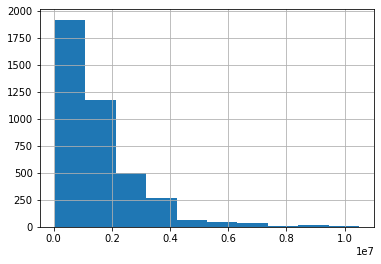

In [47]:
# Проверим цены на предмет выбросов: выбросов не обнаружено

cars.price.hist()

In [48]:
# Поскольку мы будем объединять несколько датасетов, то перекодируем значения категориальных переменных в числовые данные 

dic_bodyType = {'седан': 1, 'внедорожник': 2, 'хетчбэк': 3, 'купе': 4, 'родстер': 5, 'лифтбек': 6, 'универсал': 7, 'кабриолет': 8, 'компактвэн': 9, 'минивэн': 11}
dic_Transmis = {'автомат' : 1, 'механика': 2, 'робот': 3}
dic_color = {'чёрный': 1, 'белый': 2, 'синий': 3, 'коричневый': 4, 'красный': 5, 'серый': 6, 'бежевый': 7, 'серебристый': 8, 'золотистый': 9, 'оранжевый': 10, 'голубой': 11, 'пурпурный': 12, 'жёлтый': 13, 'зелёный': 14, 'фиолетовый': 15, 'серебряный': 8, 'золотой': 9}
dic_fuelType = {'дизель': 1, 'бензин': 2, 'гибрид': 3, 'электро': 4}
dic_privod = {'задний': 1, 'полный': 2, 'передний': 3}
dic_rul = {'Левый':1, 'Правый': 2}
dic_stat = {'Не требует ремонта': 1}
dic_PTS = {'Оригинал': 1, 'Дубликат': 2}
dic_tam = {'Растаможен': 1}

cars['bodyType'] = cars['bodyType'].map(dic_bodyType)
cars['vehicleTransmission'] = cars['vehicleTransmission'].map(dic_Transmis)
cars['color'] = cars['color'].map(dic_color)
cars['fuelType'] = cars['fuelType'].map(dic_fuelType)
cars['drive'] = cars['drive'].map(dic_privod)

cars.productionDate = cars.productionDate.astype('int32')
cars.numberOfDoors = cars.numberOfDoors.astype('int32')
cars.equipment = cars.equipment.astype('int32')
cars.price = cars.price.astype('int32')
cars.enginePower = cars.enginePower.astype('int32')

In [49]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4015 entries, 0 to 4014
Data columns (total 20 columns):
brand                  4015 non-null object
Model                  4015 non-null object
modelDate              4015 non-null object
name                   4015 non-null object
productionDate         4015 non-null int32
mileage                4015 non-null int64
state                  4015 non-null object
owners                 4015 non-null int64
bodyType               4015 non-null int64
numberOfDoors          4015 non-null int32
fuelType               4015 non-null int64
vehicleTransmission    4015 non-null int64
drive                  4015 non-null int64
wheel                  4015 non-null object
color                  4015 non-null int64
equipment              4015 non-null int32
price                  4015 non-null int32
technicalPassport      4015 non-null int64
engineDisplacement     4015 non-null object
enginePower            4015 non-null int32
dtypes: int32(5), int64(8)

In [50]:
# Проведем тест Стьюдента для определения наиболее значимых для результата признаков 

def get_student(column):
# тест Стьюдента

    cols = cars.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
#    display (combinations_all)
    for comb in combinations_all:
        if ttest_ind(cars.loc[cars.loc[:, column] == comb[0], 'price'], 
                        cars.loc[cars.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
for col in [  'brand', 'Model', 'modelDate', 'name', 'productionDate', 'mileage','state', 'owners', 'bodyType', 'numberOfDoors', 'fuelType',
       'vehicleTransmission', 'drive', 'wheel', 'color', 'equipment', 'technicalPassport', 'engineDisplacement', 'enginePower']:
    get_student(col)
    

Найдены статистически значимые различия для колонки Model
Найдены статистически значимые различия для колонки modelDate
Найдены статистически значимые различия для колонки name
Найдены статистически значимые различия для колонки productionDate
Найдены статистически значимые различия для колонки mileage
Найдены статистически значимые различия для колонки owners
Найдены статистически значимые различия для колонки bodyType
Найдены статистически значимые различия для колонки numberOfDoors
Найдены статистически значимые различия для колонки fuelType
Найдены статистически значимые различия для колонки vehicleTransmission
Найдены статистически значимые различия для колонки drive
Найдены статистически значимые различия для колонки color
Найдены статистически значимые различия для колонки equipment
Найдены статистически значимые различия для колонки technicalPassport
Найдены статистически значимые различия для колонки engineDisplacement
Найдены статистически значимые различия для колонки engine

In [51]:
# Удалим незначимые признаки: 'state','wheel', brand', а также 'Model', поскольку ее нет в тестовом датасете.

cars = cars.drop(['state','wheel','brand', 'Model'],axis = 1)

In [52]:
cars

,modelDate,name,productionDate,mileage,owners,bodyType,numberOfDoors,fuelType,vehicleTransmission,drive,color,equipment,price,technicalPassport,engineDisplacement,enginePower
0,2016,530i,1,45357,1,1,4,2,1,2,1,1,2747000,1,2.0,249
1,2009,530d,8,172467,2,1,4,1,1,2,1,1,1310000,1,3.0,258
2,2011,116i,7,193000,3,3,5,2,1,1,2,1,520000,1,1.6,136
3,2010,30d,7,104153,1,2,5,1,1,2,6,1,1759000,1,3.0,245
4,2014,35i,3,42100,2,2,5,2,1,2,2,1,2749900,1,3.0,306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4010,2015,320i,2,35000,1,1,4,2,1,1,1,2,1800000,1,2.0,184
4011,2018,30d,0,3844,1,2,5,1,1,2,6,1,5449978,1,3.0,249
4012,2013,520i,3,78000,3,1,4,2,1,1,4,2,1250000,1,2.0,184
4013,2013,520i,3,105600,1,1,4,2,1,1,1,1,1339000,1,2.0,184


In [66]:
# Наблюдаем довольно большую обратную корреляцию с пробегом, это логично.

car_corr = cars[['mileage', 'price']]
correlation = car_corr.corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

correlation.style.background_gradient(cmap, axis=1)

,mileage,price
mileage,1,-0.642103
price,-0.642103,1


In [53]:
# Сохраним в файл.

cars.to_csv(r'cars_avito.csv', index=False)

In [ ]:
# https://ru.wikipedia.org/wiki/Категория:Автомобили_BMW
# BMW_serias = ['1 (F20)', '2', 'F45', '3', '4', 'M4', '5', '5 Series Gran Turismo', '6', '6 (F13)', '7', '8', '320si WTCC', '328', '501/502', '503', '507', '700', '3200 CS', 'ActiveHybrid 7', 'E3 и E9', 'E12', 'E21', 'E23', 'E24', 'E28', 'E30', 'E31', 'E32', 'E34', 'E36', 'E38', 'E39', 'E46', 'E60', 'E65/E66', 'E87', 'E90', 'E92', 'F01', 'F10', 'F22', '3-й серии (F30)', 'F34', '3-й серии (G20)', 'G30', 'GINA', 'Hydrogen 7', 'i3', 'i8', 'Isetta', 'M1', 'M3', 'M5', 'M6', 'Neue Klasse', 'X1', 'X3', 'X4', 'X5 (E53)', 'X5 (F15)', 'X5 (E70)', 'X6', 'X7', 'Z', 'Z1', 'Z4', 'Z8']